In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


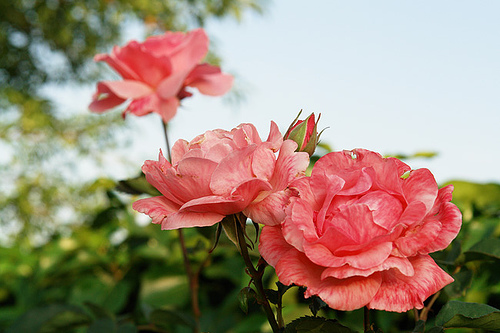

In [5]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

In [6]:
batch_size = 32
img_height = 180
img_width = 180

In [16]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [17]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [18]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
# 使用map进行scale 但本例中并没有使用这种方法，而是直接使用了一个layer
# 把归一化放到模型里
def scale(image_batch,label_batch):
  scale_image_batch=tf.divide(image_batch,255)
  return scale_image_batch,label_batch
train_ds=train_ds.map(scale)
val_ds=val_ds.map(scale)

for images,labels in train_ds.take(1):
  for image in images[:2]:
    print(image)

tf.Tensor(
[[[0.6261438  0.5588235  0.49738562]
  [0.64705884 0.57973856 0.51830065]
  [0.58431375 0.51699346 0.45555556]
  ...
  [0.68692815 0.6398693  0.59281045]
  [0.66601306 0.61895424 0.5718954 ]
  [0.679085   0.63202614 0.5849673 ]]

 [[0.6431373  0.57254905 0.5176471 ]
  [0.61764705 0.5470588  0.49215686]
  [0.64509803 0.5745098  0.51960784]
  ...
  [0.6784314  0.6313726  0.58431375]
  [0.65882355 0.6117647  0.5647059 ]
  [0.7019608  0.654902   0.60784316]]

 [[0.64379084 0.5732026  0.51830065]
  [0.67320263 0.6026144  0.54771245]
  [0.73202616 0.6614379  0.606536  ]
  ...
  [0.6503268  0.60326797 0.55620915]
  [0.7006536  0.6535948  0.606536  ]
  [0.6954248  0.648366   0.60130715]]

 ...

 [[0.6522877  0.5751636  0.53921586]
  [0.511765   0.4418304  0.4026147 ]
  [0.6705879  0.60588205 0.5725487 ]
  ...
  [0.5143791  0.4398693  0.38431373]
  [0.56732035 0.49281055 0.43398702]
  [0.592157   0.5189544  0.45947728]]

 [[0.68235296 0.6156863  0.57058823]
  [0.5901961  0.5294118  0

In [19]:
# layer
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(first_image)


tf.Tensor(
[[[1.93028331e-01 1.42047942e-01 7.53812641e-02]
  [1.88035592e-01 1.43409595e-01 7.57988393e-02]
  [1.84107989e-01 1.50502309e-01 8.04587305e-02]
  ...
  [1.34531595e-02 6.44335523e-02 0.00000000e+00]
  [1.62487868e-02 6.44155368e-02 0.00000000e+00]
  [3.50215733e-02 8.23284611e-02 0.00000000e+00]]

 [[2.14215696e-01 1.65268719e-01 9.55519304e-02]
  [2.26034880e-01 1.82897612e-01 1.02941185e-01]
  [2.31354401e-01 1.91920862e-01 1.09967329e-01]
  ...
  [5.55555522e-03 4.52614389e-02 0.00000000e+00]
  [7.40729412e-03 4.35730889e-02 9.25869390e-04]
  [2.22947057e-02 5.74071966e-02 0.00000000e+00]]

 [[3.04956436e-01 2.53976047e-01 1.79466248e-01]
  [3.18191737e-01 2.75453895e-01 1.87981129e-01]
  [3.11813146e-01 2.72597432e-01 1.73359960e-01]
  ...
  [0.00000000e+00 2.57080086e-02 9.31968971e-04]
  [0.00000000e+00 3.04646324e-02 0.00000000e+00]
  [1.94864012e-02 7.05998987e-02 4.49620374e-03]]

 ...

 [[5.32535021e-04 5.58574079e-03 0.00000000e+00]
  [1.10748957e-03 1.63943619

In [20]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
# 只有在确定了输入层的输入的时候，才能确定参数信息，才能summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [23]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 20s 219ms/step - loss: 1.4814 - accuracy: 0.3232 - val_loss: 1.2531 - val_accuracy: 0.4973

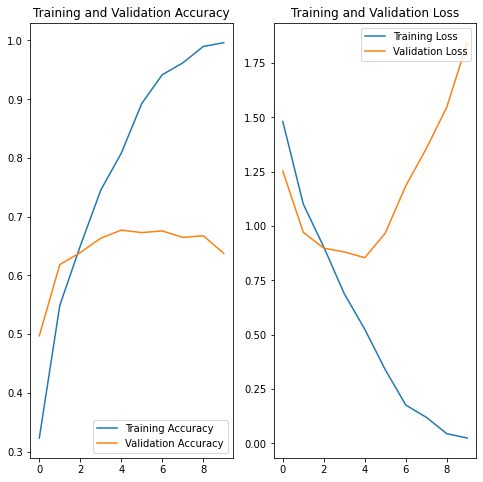

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [25]:
# 也可以使用tf.image包里的工具进行手动的扩充
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

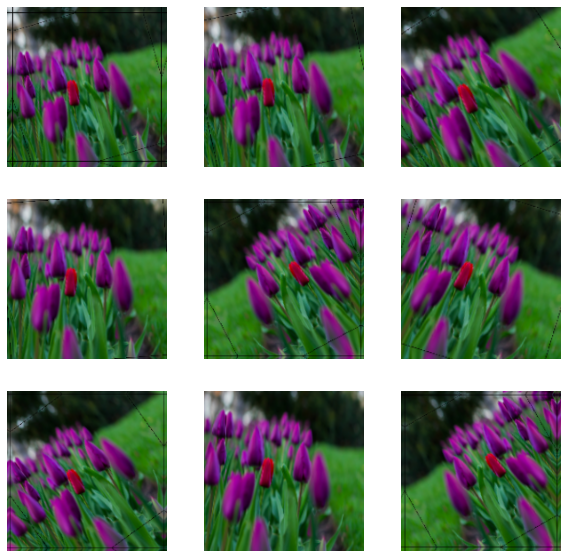

In [26]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


In [27]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [ ]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)
